### Challenge Description

Energy consumption in buildings and industry is often wasted due to user behaviour, human error, and poorly performing equipment. In this context, identifying abnormal consumption power behavior can be an important part of reducing peak energy consumption and changing undesirable user behavior. With the widespread rollouts of smart meters, normal operating consumption can be learned over time and used to identify or flag abnormal consumption. Such information can help indicate to users when their equipment is not operating as normal and can help to change user behavior or to even indicate what the problem appliances may be to implement lasting changes.

This challenge is looking for data scientists to apply their skills to an anomaly detection problem using smart meter data. Ideally, such an algorithm should begin to operate after as little as 3 months and should improve over time. A platform to visualise the anomalies would also be useful. Users can select any type of machine learning algorithms that they wish to in order to detect the anomalies from the data.

### Data
A sample including smart meter data can be found on [kaggle](https://www.kaggle.com/portiamurray/anomaly-detection-smart-meter-data-sample). Participants are encouraged to find other smart meter data to work with in order to test their algorithms.

### Imports

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import random

In [2]:
df = pd.read_excel('SmartMeterSample.xlsx')

In [24]:
df.head()

,datestamp,reading,weekday,hour,month,workday,date
0,2016-01-01 00:15:00,2.85,4,0,1,True,2016-01-01
1,2016-01-01 00:30:00,2.85,4,0,1,True,2016-01-01
2,2016-01-01 00:45:00,3.00,4,0,1,True,2016-01-01
3,2016-01-01 01:00:00,2.94,4,1,1,True,2016-01-01
4,2016-01-01 01:15:00,2.79,4,1,1,True,2016-01-01


### Rename columns

In [4]:
df.columns = ['datestamp','reading']

## First graphs

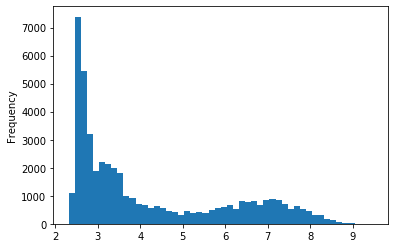

In [5]:
df['reading'].plot(kind = 'hist', bins = 50)

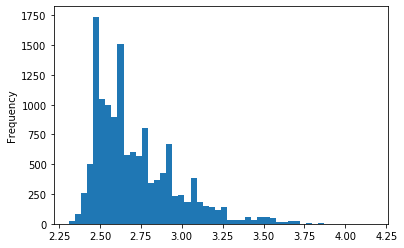

In [25]:
df[~df['workday']]['reading'].plot(kind = 'hist', bins = 50)

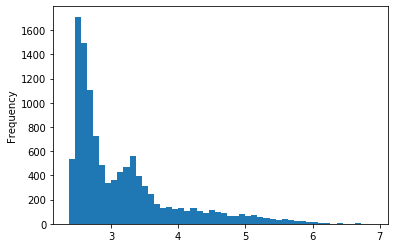

In [30]:
df[(df['workday']) & (df['hour'] < 8)]['reading'].plot(kind = 'hist', bins = 50)

### Average consumption per day of the week

In [7]:
weekday_labels = ['Mo','Tu','We','Th','Fr','Sa','Su']

In [8]:
df['weekday'] = df.apply(lambda row: row['datestamp'].weekday(), axis=1)

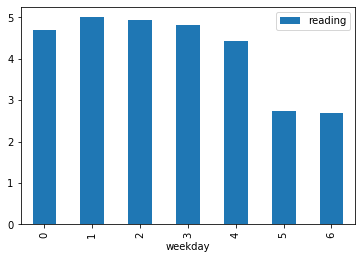

In [9]:
df[['weekday', 'reading']].groupby(['weekday']).mean().plot(kind = 'bar')

The above graph shows that on the working days (0 -- Mo, 4 -- Fr) the consumption is higher, implying that the meter is probably installed at an office rather than a household.

### Average consumption per hour

In [10]:
df['hour'] = df.apply(lambda row: row['datestamp'].hour, axis=1)

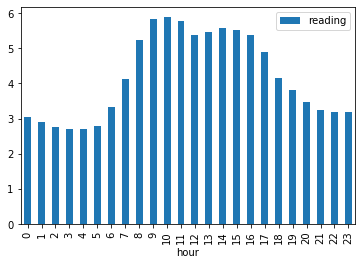

In [11]:
df[['hour', 'reading']].groupby(['hour']).mean().plot(kind = 'bar')

### Average consumption per month

In [12]:
df['month'] = df.apply(lambda row: row['datestamp'].month, axis=1)

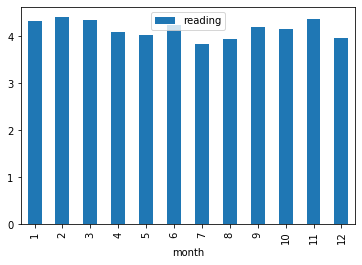

In [13]:
df[['month', 'reading']].groupby(['month']).mean().plot(kind = 'bar')

### How does a typical workday vs weekend look like?

Creating a binary feature "is it a workday?"

In [14]:
df['workday'] = df.apply(lambda row: row['weekday'] < 5, axis=1)

In [15]:
df_day_hour = df[['reading', 'weekday', 'hour', 'workday']].groupby(['weekday', 'hour']).mean()

In [16]:
df_day_hour = df_day_hour.reset_index()

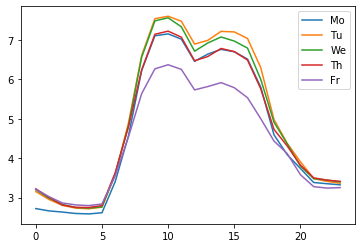

In [17]:
for idx in range(5):
    plt.plot(df_day_hour[df_day_hour['weekday'] == idx].reset_index()['reading'], label = weekday_labels[idx])
plt.legend()

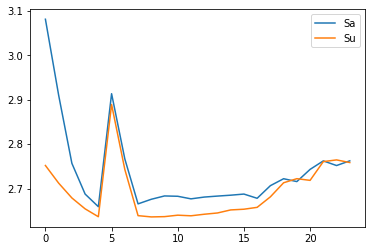

In [18]:
for idx in range(5,7):
    plt.plot(df_day_hour[df_day_hour['weekday'] == idx].reset_index()['reading'], label = weekday_labels[idx])
plt.legend()

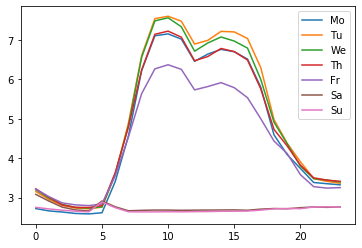

In [19]:
# all weekdays together
for idx in range(7):
    plt.plot(df_day_hour[df_day_hour['weekday'] == idx].reset_index()['reading'], label = weekday_labels[idx])
plt.legend()

# Let's classify days

In [20]:
df['date'] = df.apply(lambda row: row['datestamp'].date(), axis = 1)
f = {'reading': ['mean', 'std'], 'workday': 'mean', 'weekday': ['mean', 'count'], 'month':'mean'}
df_day = df.groupby('date').agg(f)


In [21]:
df_day[df_day[('weekday', 'count')]< 96]

reading           workday weekday       month
                mean       std    mean    mean count  mean
date                                                      
2016-01-01  2.754000  0.087585    True       4    95     1
2016-03-27  2.692174  0.113203   False       6    92     3
2016-11-10  5.059895  1.990916    True       3    95    11
2017-02-24  5.178182  1.234611    True       4    66     2
2017-03-26  2.835978  0.105289   False       6    92     3
2017-05-11  3.570000       NaN    True       3     1     5

In [22]:
df_day = df_day.dropna()
df_day

reading           workday weekday       month
                mean       std    mean    mean count  mean
date                                                      
2016-01-01  2.754000  0.087585    True       4    95     1
2016-01-02  2.723125  0.036283   False       5    96     1
2016-01-03  2.725937  0.035528   False       6    96     1
2016-01-04  5.222500  2.211100    True       0    96     1
2016-01-05  5.040938  2.022156    True       1    96     1
...              ...       ...     ...     ...   ...   ...
2017-05-06  3.014375  0.089099   False       5    96     5
2017-05-07  3.027812  0.083982   False       6    96     5
2017-05-08  5.157812  2.043110    True       0    96     5
2017-05-09  5.167500  1.916844    True       1    96     5
2017-05-10  4.946250  1.681591    True       2    96     5

[496 rows x 6 columns]

In [23]:
df_day.columns = ['reading-mean', 'reading-std', 'workday', 'weekday','month']

ValueError: Length mismatch: Expected axis has 6 elements, new values have 5 elements

In [ ]:
plt.plot(df_day[df_day['workday']]['reading-mean'], df_day[df_day['workday']]['reading-std'], 'bo', alpha = 0.1)
plt.plot(df_day[~df_day['workday']]['reading-mean'], df_day[~df_day['workday']]['reading-std'], 'go', alpha = 0.1)

   ### DBSCAN clustering of days

In [100]:
X = df_day[['reading-mean','reading-std']]
X = StandardScaler().fit_transform(X)

In [135]:
db = DBSCAN(eps = 0.2, min_samples = 3).fit(X)
set(db.labels_)

{-1, 0, 1, 2}

In [136]:
df_day['DB-label'] = db.labels_

/scratch/users/golubevk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


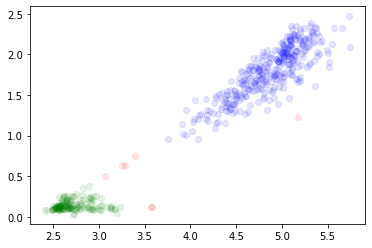

In [144]:
plt.plot(df_day[df_day['DB-label']==0]['reading-mean'], df_day[df_day['DB-label']==0]['reading-std'], 'go', alpha = 0.1)
plt.plot(df_day[df_day['DB-label']==1]['reading-mean'], df_day[df_day['DB-label']==1]['reading-std'], 'bo', alpha = 0.1)
plt.plot(df_day[~(df_day['DB-label']==0) & ~(df_day['DB-label']==1)]['reading-mean'], df_day[~(df_day['DB-label']==0) & ~(df_day['DB-label']==1)]['reading-std'], 'ro', alpha = 0.1)


In [150]:
df_day_outliers = df_day[~(df_day['DB-label']==1) & ~(df_day['DB-label']==0)]

In [158]:
df_day_outliers

,date,reading-mean,reading-std,workday,weekday,month,DB-label
0,2016-05-06,3.390313,0.743925,True,4,5,2
1,2016-12-27,3.283125,0.641051,True,1,12,2
2,2016-12-28,3.249375,0.619488,True,2,12,2
3,2016-12-29,3.063125,0.503193,True,3,12,-1
4,2017-02-11,3.582187,0.122313,False,5,2,-1
5,2017-02-12,3.565625,0.122962,False,6,2,-1
6,2017-02-24,5.178182,1.234611,True,4,2,-1


### Let's go over outliers one by one

In [307]:
df_day_outliers = df_day_outliers.reset_index()

In [311]:
ido = 4 # takes values from 0 to 6, as there are 7 outliers

In [312]:
# what day of the week it is
wd = int(df[df['date'] == df_day_outliers.iloc[ido]['date']]['weekday'].mean());
wd

5

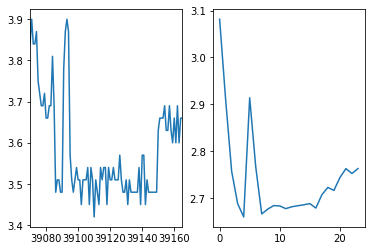

In [313]:
plt.subplot(1, 2, 1)
df[df['date'] == df_day_outliers.iloc[ido]['date']]['reading'].plot()
plt.subplot(1, 2, 2)
plt.plot(df_day_hour[df_day_hour['weekday'] == wd].reset_index()['reading'], label = weekday_labels[wd])

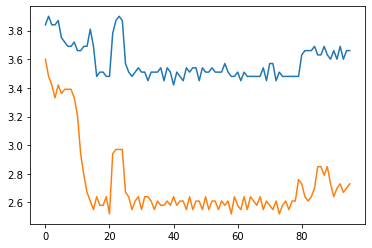

In [318]:
l = len(df[df['weekday'] == wd])
idr = random.randint(0,l-1)
idr_date = df[df['weekday'] == wd].iloc[idr]['date']
'''
plt.subplot(1, 3, 1)
df[df['date'] == df_day_outliers.iloc[ido]['date']]['reading'].plot()
plt.subplot(1, 3, 2)
df[df['date'] == idr_date]['reading'].plot()
plt.subplot(1, 3, 3)
'''
plt.plot(df[df['date'] == df_day_outliers.iloc[ido]['date']].reset_index()['reading'])
plt.plot(df[df['date'] == idr_date].reset_index()['reading'])
plt.show()

In [286]:
idr_date

datetime.date(2017, 1, 27)

In [274]:
df[df['date'] == df_day_outliers.iloc[ido]['date']]

,datestamp,reading,weekday,hour,month,workday,date
40318,2017-02-24 07:30:00,4.86,4,7,2,True,2017-02-24
40319,2017-02-24 07:45:00,5.10,4,7,2,True,2017-02-24
40320,2017-02-24 08:00:00,5.25,4,8,2,True,2017-02-24
40321,2017-02-24 08:15:00,5.34,4,8,2,True,2017-02-24
40322,2017-02-24 08:30:00,5.82,4,8,2,True,2017-02-24
...,...,...,...,...,...,...,...
40379,2017-02-24 22:45:00,3.18,4,22,2,True,2017-02-24
40380,2017-02-24 23:00:00,3.12,4,23,2,True,2017-02-24
40381,2017-02-24 23:15:00,3.15,4,23,2,True,2017-02-24
40382,2017-02-24 23:30:00,3.21,4,23,2,True,2017-02-24


### Conclusions

**Outlier #1**: probably just less people were in the office. It is May 6, 2016, and it was a Friday after a Thursday off.

**Outlier #2-4**: same as #1 (right after Christmas)

**Outlier #5-6**: weirdly high and constant consumption over the weekend. The pattern is the same as for the days off, but consumption is higher.

**Outlier #7**: probably because the meter was not recording 0:00 -- 7:15.